# 🦚 Perception
Detecting suspicious communication specificly (cyber bulling, threatning, terirosim ) from any type of txt data

**Important notes:**

- *NLTK* is a leading platform for building Python programs to work with human language data. The Natural Language Toolkit (NLTK) is an open source Python library for Natural Language Processing.

- *sklearn* is a free software machine learning library for the Python programming language, it features various classification, regression and clustering algorithms including support vector machines, random forests, gradient boosting, k-means and DBSCAN.

- *Seaborn* is a Python data visualization library based on matplotlib.

- *pandas* 

- *numpy*

In [36]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from nltk.corpus import stopwords
import pickle
import matplotlib.pyplot as plt

import re, os
for dirname, _, filenames in os.walk('/home/dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## 📜 Data

In [37]:
df = pd.read_csv('data/dataset/suspicious-tweets.csv')

df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
0        6145   6133  Put vacation photos online a few yrs ago. PC c...    2
1       53855  53574                             @tweetchild  Clean Me!    7

In [38]:
# Count the number of characters in each message
df['length'] = df['message'].apply(len)
df.head()

,message,label,length
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",1,115
1,is upset that he can't update his Facebook by ...,1,111
2,@Kenichan I dived many times for the ball. Man...,1,89
3,my whole body feels itchy and like its on fire,0,47
4,"@nationwideclass no, it's not behaving at all....",1,111


In [39]:
# Use for pre-test only 11 number of elements!
df_labels = df['label']
df_labels.head()

0    1
1    1
2    1
3    0
4    1
Name: label, dtype: int64

### Data representation

Suspicious:  6145
Non-Suspicious:  53855


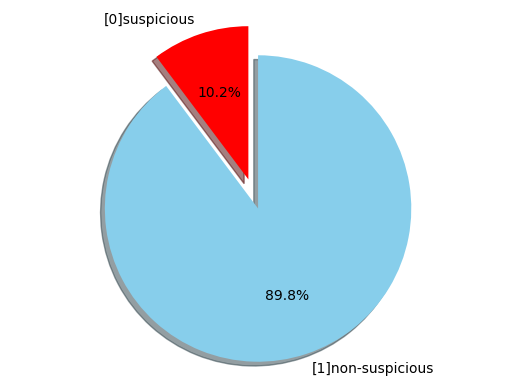

In [40]:
# Only for hinstogram
count_Class = pd.value_counts(df.label, sort = True)
print("Suspicious: ", count_Class[0])
print("Non-Suspicious: ", count_Class[1])

# Data
labels = '[0]suspicious', '[1]non-suspicious'
sizes = [count_Class[0], count_Class[1]]
colors = ['red', 'skyblue']
explode = (0.1, 0.1)


plt.pie(sizes, explode = explode, labels = labels, colors = colors,
        autopct = '%1.1f%%', shadow = True, startangle = 90)
plt.axis('equal')
plt.show()

### Data cleaning

**Important notes:**
- The *Porter stemming* algorithm (or 'Porter stemmer') is a process for removing the commoner morphological and inflexional endings from words in English. Its main use is as part of a term normalisation process that is usually done when setting up Information Retrieval systems.

In [41]:
# Preprocess text and clean string
def preprocess_text(sen):
    sentence = re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)',' ',sen) # Removing html tags
    sentence = re.sub('[^a-zA-Z]', ' ', sentence) # Remove punctuations and numbers
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) # Single character removal
    sentence = re.sub(r'\s+', ' ', sentence) # Removing multiple spaces
    sentence = sentence.replace("ain't", "am not").replace("aren't", "are not")
    sentence = ' '.join(text.lower() for text in sentence.split(' ')) # Lowering cases
    sw = stopwords.words('english')
    sentence = ' '.join(text for text in sentence.split() if text not in sw) #removing stopwords
    #sentence = ' '.join(text.lemmatize() for text in sentence.split()) #lemmatization
    return sentence

In [42]:
nltk.download('stopwords')
nltk.download('punkt')
# Save in message, clean text
df['message'] = df.message.apply(preprocess_text)
# Tokenization each text
df['message'] = df['message'].apply(nltk.word_tokenize)

stemmer = PorterStemmer()
df['message'] = df['message'].apply(lambda x: [stemmer.stem(y) for y in x])

[nltk_data] Downloading package stopwords to /home/peppe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/peppe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [43]:
# is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
# -> ['upset', 'updat', 'facebook', 'text', 'might', 'cri', 'result', 'school', 'today', 'blah']
show = df['message']
show.head()

0    [switchfoot, bummer, shoulda, got, david, carr...
1                       [upset, updat, facebook, text]
2    [kenichan, dive, mani, time, ball, manag, save...
3               [whole, bodi, feel, itchi, like, fire]
4                   [nationwideclass, behav, mad, see]
Name: message, dtype: object

### Data processing
**Important notes:**
- *CountVectorizer* Convert a collection of text documents to a matrix of token counts. This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix. If you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection then the number of features will be equal to the vocabulary size found by analyzing the data.

- *TfidfTransformer* Transform a count matrix to a normalized tf or tf-idf representation. Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification. The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [44]:
df['message'] = df['message'].apply(lambda x: ' '.join(x))

# Convert a collection of text documents to a matrix of token counts.
count_vect = CountVectorizer()
counts = count_vect.fit_transform(df['message']);

In [45]:
transformer = TfidfTransformer().fit(counts)
counts = transformer.fit_transform(counts)

### Data split

In [46]:
# Separe dataset in traning and test(30%)
X_train, X_test, y_train, y_test = train_test_split(counts, df['label'], test_size=0.3, random_state=69)

## 🐱‍🏍 Learning models

### Naive bayes and evaluation

**Impotant notes:**
- Compute *confusion matrix* to evaluate the accuracy of a classification.

Evaluation metrics can be applied such as:

- *Confusion Matrix:* a table showing correct predictions and types of incorrect predictions. A confusion matrix is a technique for summarizing the performance of a classification algorithm. Classification accuracy alone can be misleading if you have an unequal number of observations in each class or if you have more than two classes in your dataset. Calculating a confusion matrix can give you a better idea of what your classification model is getting right and what types of errors it is making.
- *Precision:* the number of true positives divided by all positive predictions. Precision is also called Positive Predictive Value. It is a measure of a classifier’s exactness. Low precision indicates a high number of false positives.
- *Recall:* the number of true positives divided by the number of positive values in the test data. Recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier’s completeness. Low recall indicates a high number of false negatives.
- *F1-Score:* the weighted average of precision and recall.

In [47]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [48]:
# implementing naive bayes
NB = MultinomialNB().fit(X_train, y_train)

predicted = NB.predict(X_test)
print(np.mean(predicted == y_test))

0.9002222222222223


In [49]:
# Confronto etichette corrette dei dati di test (y) con le risposte elaborate dal programma (predicted).
error = accuracy_score(y_test, predicted)
print(f"Accuracy: {error}")

Accuracy: 0.9002222222222223


In [50]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       1.00      0.04      0.08      1869
           1       0.90      1.00      0.95     16131

    accuracy                           0.90     18000
   macro avg       0.95      0.52      0.51     18000
weighted avg       0.91      0.90      0.86     18000



**Confusion Matrix specifically**, it computes:

- True positives (TP)
  - The model predicted true and it is true.
  - The model predicted that someone message is SUSPICIOUS and the message is SUSPICIOUS.
- False positives (FP)
  - The model predicted false and it is false.
  - The model predicted that someone message is NOT-SUSPICIOUS and the message is NOT-SUSPICIOUS.
- True negatives (TN)
  - The model predicted True and it is false.
  - The model predicted that someone message is SUSPICIOUS and the message is NOT-SUSPICIOUS.
- False negatives (FN)
  - The model predicted false and it is true.
  - The model predicted that someone message is NOT-SUSPICIOUS and the message is SUSPICIOUS.

![Confusion-matrix](resources/confusion-matrix.png)

[[ 1314   555]
 [   65 16066]]


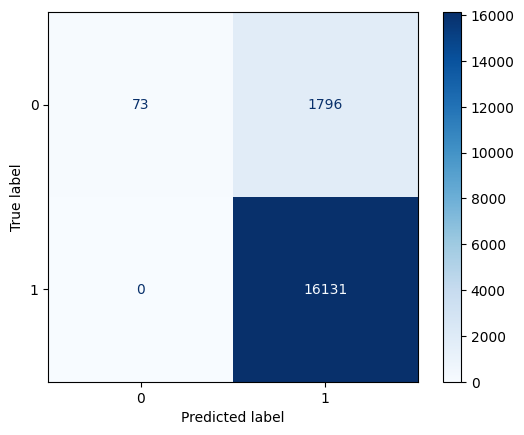

In [77]:
# Compute confusion matrix to evaluate the accuracy of a classification
print(confusion_matrix(y_test, predicted))

ConfusionMatrixDisplay.from_estimator(NB, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

### SVC
C-Support Vector Classification. The implementation is based on libsvm. The fit time scales at least quadratically with the number of samples and may be impractical beyond tens of thousands of samples.

In [52]:
# implementing SVM
sv = SVC().fit(X_train, y_train)

predicted = sv.predict(X_test)
print(np.mean(predicted == y_test))

0.9588888888888889


In [53]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.97      0.62      0.76      1869
           1       0.96      1.00      0.98     16131

    accuracy                           0.96     18000
   macro avg       0.96      0.81      0.87     18000
weighted avg       0.96      0.96      0.95     18000



[[ 1314   555]
 [   65 16066]]


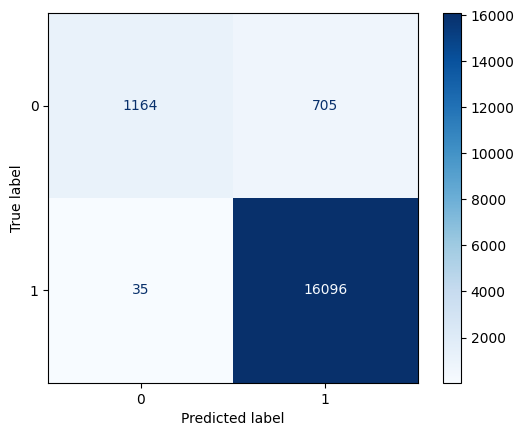

In [72]:
print(confusion_matrix(y_test, predicted))

ConfusionMatrixDisplay.from_estimator(sv, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

### Decision tree classifier
Decision tree builds classification or regression models in the form of a tree structure. It breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes.

In [55]:
# implementing disession tree
dt = DecisionTreeClassifier().fit(X_train, y_train)

predicted = dt.predict(X_test)
print(np.mean(predicted == y_test))

0.9727222222222223


In [56]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1869
           1       0.98      0.99      0.98     16131

    accuracy                           0.97     18000
   macro avg       0.94      0.91      0.92     18000
weighted avg       0.97      0.97      0.97     18000



[[ 1314   555]
 [   65 16066]]


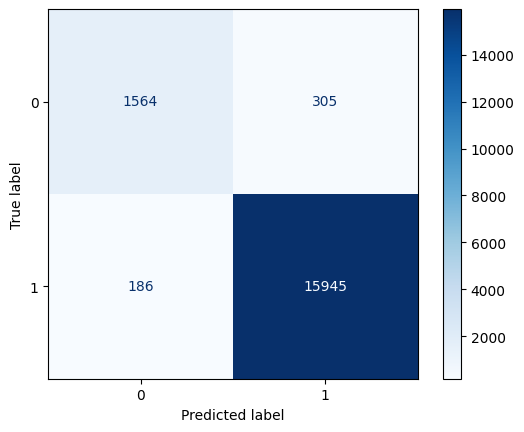

In [78]:
print(confusion_matrix(y_test, predicted))

ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

### An AdaBoost classifier
An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

This class implements the algorithm known as AdaBoost-SAMME.

In [58]:
# implementing adabost
ab = AdaBoostClassifier().fit(X_train, y_train)

predicted = ab.predict(X_test)
print(np.mean(predicted == y_test))

0.9655555555555555


In [59]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.95      0.70      0.81      1869
           1       0.97      1.00      0.98     16131

    accuracy                           0.97     18000
   macro avg       0.96      0.85      0.90     18000
weighted avg       0.97      0.97      0.96     18000



[[ 1314   555]
 [   65 16066]]


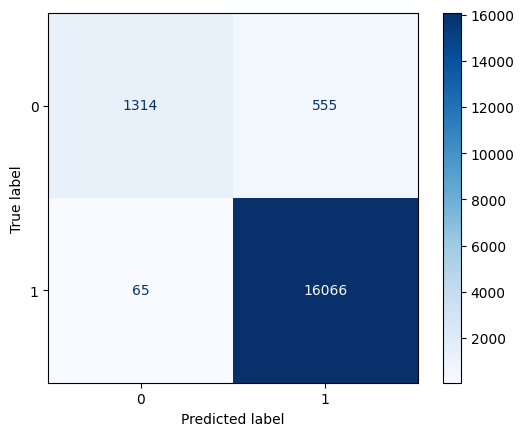

In [79]:
print(confusion_matrix(y_test, predicted))

ConfusionMatrixDisplay.from_estimator(ab, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

## 📊 Finalize learning

**Important notes:**
- **Transform** documents to document-term matrix. Extract token counts out of raw text documents using the vocabulary fitted with fit or the one provided to the constructor.

- **Predict** class or regression value for X. For a classification model, the predicted class for each sample in X is returned. For a regression model, the predicted value based on X is returned.

In [61]:
# converting content to lower case
pred = (df['message'].str.lower())
# printing predictions made by model
print("prediction: {}". format(dt.predict(count_vect.transform(pred.values.astype('U')))))
# saving predictions in a variable
my_pred = dt.predict(count_vect.transform(pred.values.astype('U')))

# saving predicted labels in .csv file
df['autotag'] = my_pred
df.to_csv('data/dataset/result.csv',index = False)

prediction: [1 1 1 ... 1 1 1]


## 📊 Valutate and results

In [62]:
# getting the number of -ve , +ve  predictions 
positive = 0
negative = 0

for v in my_pred:
 if (v == 1):
  positive += 1
 elif (v == 0):
  negative += 1

In [63]:
# function for quality measurement (can be set to required parameters)
def quality(pos,total):
    if((pos*100)/total >= 0 and (pos*100)/total <=24 ):
        print('Quality: Very Negative')
    elif((pos*100)/total >= 25 and (pos*100)/total <=49 ):
        print('Quality: Negative')
    elif((pos*100)/total >= 50 and (pos*100)/total <=74 ):
        print('Quality: Positive')
    elif((pos*100)/total >= 75 and (pos*100)/total <=100 ):
        print('Quality: Very Positive')

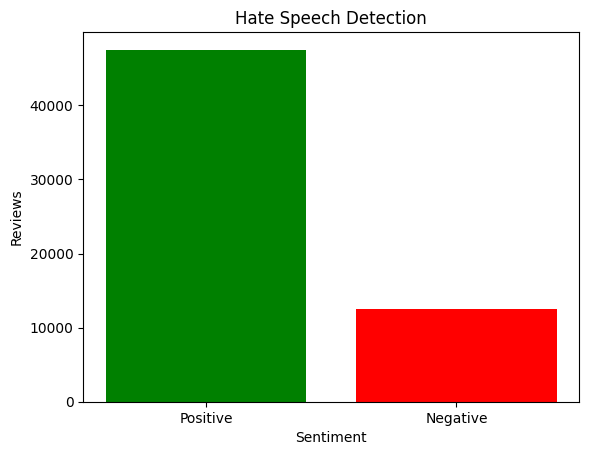

Sentiment - Positive: 47500, Negative: 12500
Quality: Very Positive


In [64]:
# importing library to plot charts
import matplotlib.pyplot as plt 
  
# x-coordinates of left sides of bars  
left = [100, 200] 

# heights of bars 
height = [positive,negative]
  
# labels for bars 
tick_label = ['Positive', 'Negative'] 
  
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, width = 80, color = ['green','red']) 
  
# naming the x-axis 
plt.xlabel('Sentiment') 
# naming the y-axis 
plt.ylabel('Reviews') 
# plot title 
plt.title('Hate Speech Detection') 
  
# function to show the plot 
plt.show() 
print ("Sentiment - Positive: "+str(positive)+", Negative: "+str(negative))
quality(positive,(positive+negative))

In [65]:
# getting negativity 
negativeity = (negative*100)/(positive+negative)
positivity = (positive*100)/(positive+negative)
print("Negativeity: "+str(negativeity)+"%")
print("Positivity: "+str(positivity)+"%")

Negativeity: 20.833333333333332%
Positivity: 79.16666666666667%


## 💡 Random Oversampling (under)

This technique is used to modify the unequal data classes to create balanced datasets. When the quantity of data is insufficient, the oversampling method tries to balance by incrementing the size of rare samples.

(Or)

Over-sampling increases the number of minority class members in the training set. The advantage of over-sampling is that no information from the original training set is lost, as all observations from the minority and majority classes are kept. On the other hand, it is prone to over fitting.

- Advantages:
  - No loss of information
  - Mitigate overfitting caused by oversampling.
- Disadvantages:
  - Overfitting
- Specifications: 
  - Random Oversampling: $not \;majority$ = resample all classes but the majority class
  - Random Undersampling: $not \;minority$ = resample all classes but the minority class

0    4276
1    4276
Name: label, dtype: int64

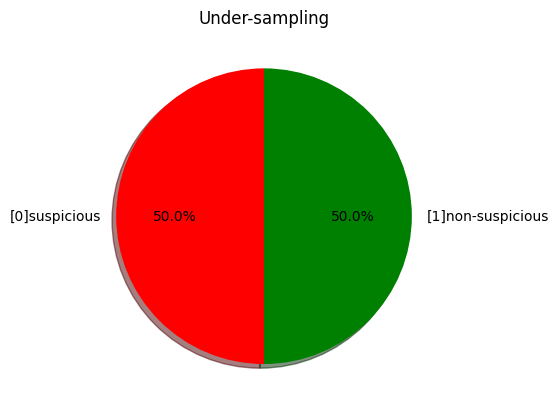

In [66]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy="not minority") # Numerical value

X_resample, y_resample = rus.fit_resample(X_train, y_train)

labels = '[0]suspicious', '[1]non-suspicious'

ax = y_resample.value_counts().plot.pie(autopct='%1.1f%%', labels=labels, colors=['red','green'], shadow = True, startangle = 90, ylabel='')

_ = ax.set_title("Under-sampling")

y_resample.value_counts()

In [67]:
# implementing naive bayes
NB_os = MultinomialNB().fit(X_resample, y_resample)

predicted_nb = NB_os.predict(X_test)
print("predicted_nb: ", np.mean(predicted_nb == y_test))

# implementing SVM
sv_os = SVC().fit(X_resample, y_resample)

predicted_sv = sv_os.predict(X_test)
print("predicted_sv: ", np.mean(predicted_sv == y_test))

# implementing disession tree
dt_os = DecisionTreeClassifier().fit(X_resample, y_resample)

predicted_dt = dt_os.predict(X_test)
print("predicted_dt: ", np.mean(predicted_dt == y_test))

# implementing adabost
ab_os = AdaBoostClassifier().fit(X_resample, y_resample)

predicted_ab = ab_os.predict(X_test)
print("predicted_ab: ", np.mean(predicted_ab == y_test))

predicted_nb:  0.683
predicted_sv:  0.9566111111111111
predicted_dt:  0.8260555555555555
predicted_ab:  0.9648888888888889


In [74]:
print("MultinomialNB: \n", classification_report(y_test,predicted_nb))
#print("MultinomialNB: ", confusion_matrix(y_test, predicted_nb))

print("SVC: \n", classification_report(y_test,predicted_sv))
#print("SVC: ", confusion_matrix(y_test, predicted_sv))

print("DecisionTreeClassifier: \n", classification_report(y_test,predicted_dt))
#print("DecisionTreeClassifier: ", confusion_matrix(y_test, predicted_dt))

print("AdaBoostClassifier: \n", classification_report(y_test,predicted_ab))
#print("AdaBoostClassifier: ", confusion_matrix(y_test, predicted_ab))

MultinomialNB: 
               precision    recall  f1-score   support

           0       0.24      0.92      0.38      1869
           1       0.99      0.66      0.79     16131

    accuracy                           0.68     18000
   macro avg       0.61      0.79      0.58     18000
weighted avg       0.91      0.68      0.74     18000

SVC: 
               precision    recall  f1-score   support

           0       0.80      0.78      0.79      1869
           1       0.97      0.98      0.98     16131

    accuracy                           0.96     18000
   macro avg       0.89      0.88      0.88     18000
weighted avg       0.96      0.96      0.96     18000

DecisionTreeClassifier: 
               precision    recall  f1-score   support

           0       0.36      0.90      0.52      1869
           1       0.99      0.82      0.89     16131

    accuracy                           0.83     18000
   macro avg       0.67      0.86      0.71     18000
weighted avg       0.92 

NB_os: 


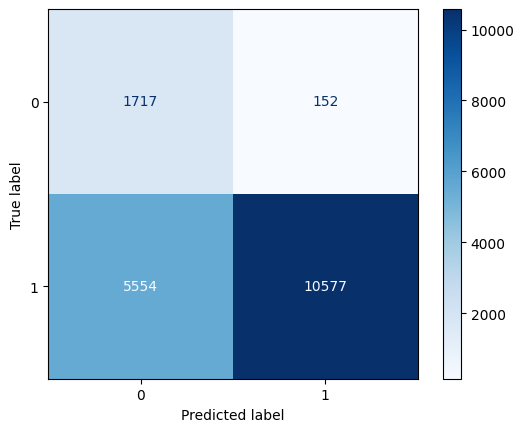

sv_os: 


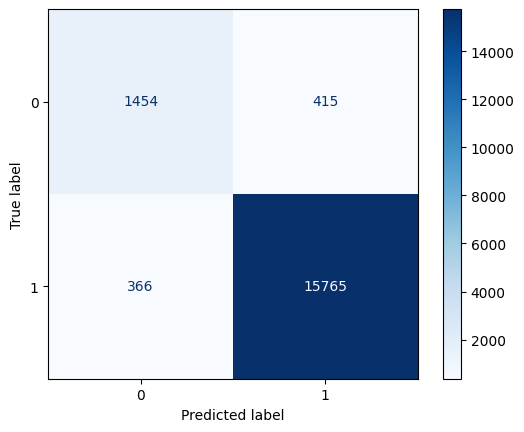

dt_os: 


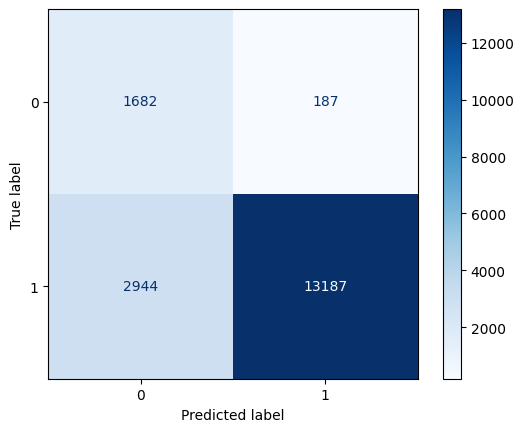

ab_os: 


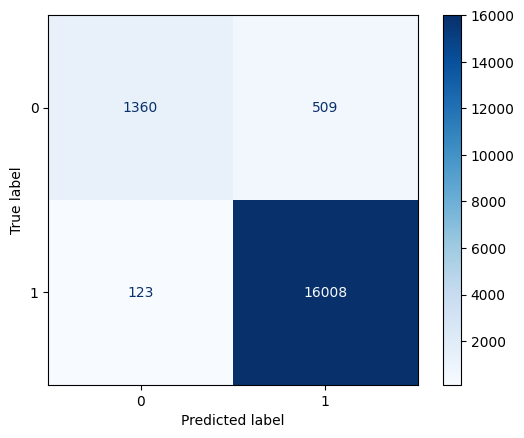

In [76]:
print("NB_os: ")
ConfusionMatrixDisplay.from_estimator(NB_os, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

print("sv_os: ")
ConfusionMatrixDisplay.from_estimator(sv_os, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

print("dt_os: ")
ConfusionMatrixDisplay.from_estimator(dt_os, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

print("ab_os: ")
ConfusionMatrixDisplay.from_estimator(ab_os, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

## 💡 K-fold cross-validation (normal)

In [69]:
# Implement K fold cross-validation
from sklearn.model_selection import cross_val_score
cv = 2

nb_accuracy = cross_val_score(estimator = NB, X = X_train, y = y_train, cv = cv)
print("[nb] Accuracy: {:.2f} %".format(nb_accuracy.mean()*100))
print("[nb] Standard Deviation: {:.2f} %".format(nb_accuracy.std()*100))

sv_accuracy = cross_val_score(estimator = sv, X = X_train, y = y_train, cv = cv)
print("[sv] Accuracy: {:.2f} %".format(sv_accuracy.mean()*100))
print("[sv] Standard Deviation: {:.2f} %".format(sv_accuracy.std()*100))

dt_accuracies = cross_val_score(estimator = dt, X = X_train, y = y_train, cv = cv)
print("[dt] Accuracy: {:.2f} %".format(dt_accuracies.mean()*100))
print("[dt] Standard Deviation: {:.2f} %".format(dt_accuracies.std()*100))

ab_accuracies = cross_val_score(estimator = ab, X = X_train, y = y_train, cv = cv)
print("[ab] Accuracy: {:.2f} %".format(ab_accuracies.mean()*100))
print("[ab] Standard Deviation: {:.2f} %".format(ab_accuracies.std()*100))

[nb] Accuracy: 89.92 %
[nb] Standard Deviation: 0.00 %
[sv] Accuracy: 94.61 %
[sv] Standard Deviation: 0.06 %
[dt] Accuracy: 97.06 %
[dt] Standard Deviation: 0.01 %
[ab] Accuracy: 96.29 %
[ab] Standard Deviation: 0.01 %


## 💡 K-fold cross-validation (undersampling)

In [70]:
# Implement K fold cross-validation
from sklearn.model_selection import cross_val_score
cv = 2

nb_accuracy = cross_val_score(estimator = NB_os, X = X_resample, y = y_resample, cv = cv)
print("[nb] Accuracy: {:.2f} %".format(nb_accuracy.mean()*100))
print("[nb] Standard Deviation: {:.2f} %".format(nb_accuracy.std()*100))

sv_accuracy = cross_val_score(estimator = sv_os, X = X_resample, y = y_resample, cv = cv)
print("[sv] Accuracy: {:.2f} %".format(sv_accuracy.mean()*100))
print("[sv] Standard Deviation: {:.2f} %".format(sv_accuracy.std()*100))

dt_accuracies = cross_val_score(estimator = dt_os, X = X_resample, y = y_resample, cv = cv)
print("[dt] Accuracy: {:.2f} %".format(dt_accuracies.mean()*100))
print("[dt] Standard Deviation: {:.2f} %".format(dt_accuracies.std()*100))

ab_accuracies = cross_val_score(estimator = ab_os, X = X_resample, y = y_resample, cv = cv)
print("[ab] Accuracy: {:.2f} %".format(ab_accuracies.mean()*100))
print("[ab] Standard Deviation: {:.2f} %".format(ab_accuracies.std()*100))

[nb] Accuracy: 75.39 %
[nb] Standard Deviation: 0.76 %
[sv] Accuracy: 83.29 %
[sv] Standard Deviation: 0.32 %
[dt] Accuracy: 82.61 %
[dt] Standard Deviation: 0.74 %
[ab] Accuracy: 83.29 %
[ab] Standard Deviation: 0.22 %


## 💡 Pickle model and show score

In [71]:
# NB = MultinomialNB().fit(X_train, y_train)
# sv = SVC().fit(X_train, y_train)
# dt = DecisionTreeClassifier().fit(X_train, y_train)
# ab = AdaBoostClassifier().fit(X_train, y_train)

path = 'data/modelSave/'

nb_fileModel = path + 'nb_model.sav'
sv_fileModel = path + 'sv_model.sav'
dt_fileModel = path + 'dt_model.sav'
ab_fileModel = path + 'ab_model.sav'

pickle.dump(NB, open(nb_fileModel, 'wb'))
pickle.dump(sv, open(sv_fileModel, 'wb'))
pickle.dump(dt, open(dt_fileModel, 'wb'))
pickle.dump(ab, open(ab_fileModel, 'wb'))

In [ ]:
nb_loaded_model = pickle.load(open(nb_fileModel, 'rb'))
sv_loaded_model = pickle.load(open(sv_fileModel, 'rb'))
dt_loaded_model = pickle.load(open(dt_fileModel, 'rb'))
ab_loaded_model = pickle.load(open(ab_fileModel, 'rb'))

# Predicting the Test set results
nb_pred = nb_loaded_model.predict(X_test)
print("MultinomialNB: ", nb_loaded_model.score(X_test, y_test))

sv_pred = sv_loaded_model.predict(X_test)
print("SVC: ", sv_loaded_model.score(X_test, y_test))

dt_pred = dt_loaded_model.predict(X_test)
print("DecisionTreeClassifier: ", dt_loaded_model.score(X_test, y_test))

ab_pred = ab_loaded_model.predict(X_test)
print("AdaBoostClassifier: ", ab_loaded_model.score(X_test, y_test))